## Buffer du cours DQN

In [2]:
import random
import torch

class Buffer:
    def __init__(self, capacity):
        self.capacity = capacity # capacity of the buffer
        self.data = []
        self.index = 0 # index of the next cell to be filled

    def append(self, s, a, r, s_, d):
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity
    
    def get(self):
        state = np.stack([self.data[i][0] for i in range(len(self.data))])
        action = np.stack([self.data[i][1] for i in range(len(self.data))])
        action = np.expand_dims(action, axis=1)
        reward = np.array([self.data[i][2] for i in range(len(self.data))])
        next_state = np.stack([self.data[i][3] for i in range(len(self.data))])
        done = np.array([self.data[i][4] for i in range(len(self.data))])
        
        return state, action, reward, next_state, done

    def len(self):
        return len(self.data)

## Requêter le simulateur
### Création de l'échantillon initial

In [3]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from hiv_patient import HIVPatient
from tqdm import trange

In [4]:
# Simulate unhealthy patient
patient = HIVPatient(clipping=False,logscale=False)
buff = Buffer(12000)
step = 1 # Pour les tests petit step

# Actions : OneHotEncoder
#action = { 0 : np.array([0, 0, 0, 1]), 1 : np.array([0, 0, 1, 0]), 2 : np.array([0, 1, 0, 0]), 3 : np.array([1, 0, 0, 0])}
action = np.array([0, 1, 2, 3])

# Fill buffer with initial sample randomly generated
for j in range(step):
    s = patient.reset(mode="unhealthy")
    dur = 4000 # 200 jours / 5 jours
    for i in trange(200):
        a = np.random.randint(3)
        s_, r, d, _ = patient.step(a)
        s = s_
        buff.append(s,a,r,s_,d)
        


100%|█████████████████████████████████████████| 200/200 [00:11<00:00, 16.91it/s]


## Fonction update de l'estimator

In [5]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor
from typing import Optional, List

def update(memory : Buffer, action_list : List[np.ndarray], gamma : float = 0.98, estimator_factory  : RandomForestRegressor = RandomForestRegressor, estimator : Optional[BaseEstimator] = None):
    state, action, reward, _, done = memory.get()
    x_list = np.concatenate((state,action),axis=1)
    target = reward
    qmax = []
        
    if estimator is not None:
        q_values = np.zeros((len(state),0))
        
        for a in action_list:
            a_ = a*np.ones((len(state),1))
            X = np.concatenate((state,a_),axis=1)
            e = estimator.predict(X)
            e = np.expand_dims(e, axis=1)
            q_values = np.concatenate((q_values,e),axis=1)
            
        qmax = q_values.max(axis=1)
        target += gamma*qmax * (1-done)
    
    if estimator is None:
        estimator = estimator_factory()
        
        
    estimator.fit(x_list, target)
    
    return estimator

## Entrainement

In [6]:
# Fill buffer with next sample : 85% strategy from last sample, 15% random

print('Buffer length at step ',j)
print(buff.len())
s = patient.reset(mode="unhealthy")
dur = 4000 # 2000 jours / 5 jours
e = None
e = update(buff, action, estimator = e)
    
for i in trange(200):
    k = np.random.rand()
    a = 0
        
    if k < 0.15:   
        a = np.random.randint(3)
            
    else:
        q_list = []
            
        for aa in action:
            a_ = aa*np.ones((1,1))
            ss = np.expand_dims(s, axis=0)
            sa = np.concatenate((ss,a_),axis=1)
            q = e.predict(sa)
            q_list.append(q)
            
        i = q_list.index(max(q_list))
        a = action[i]
            
            
    s_, r, d, _ = patient.step(a)
    buff.append(s,a,r,s_,d)
    s = s_
        
    if i%20:
        e = update(buff, action, estimator = e)
            

Buffer length at step  0
200


100%|█████████████████████████████████████████| 200/200 [00:36<00:00,  5.46it/s]


## Tracer les courbes (merci Paul)

In [8]:
s = patient.reset(mode="unhealthy")
T1,T2,T1_,T2_,V,E = np.zeros(200), np.zeros(200), np.zeros(200), np.zeros(200), np.zeros(200), np.zeros(200)

for step in trange(200):
    T1[step], T2[step], T1_[step], T2_[step], V[step], E[step] = s 

    greedy = np.zeros((4,2))
        
    for a in range(4):
        sta = np.expand_dims(s,axis=1)
        act = np.expand_dims(np.array([a]),axis=1)
        X = np.concatenate((sta,act),axis=0).T
        q = e.predict(X)
        greedy[a,0] , greedy[a,1] = a , q

    
    action = greedy[np.argmax(greedy[:,0]),0]   


    s_, r, d, _ = patient.step(int(action))
    buff.append(s,a,r,s_,d)
    s = s_

100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.96it/s]


Text(0.5, 1.0, 'E')

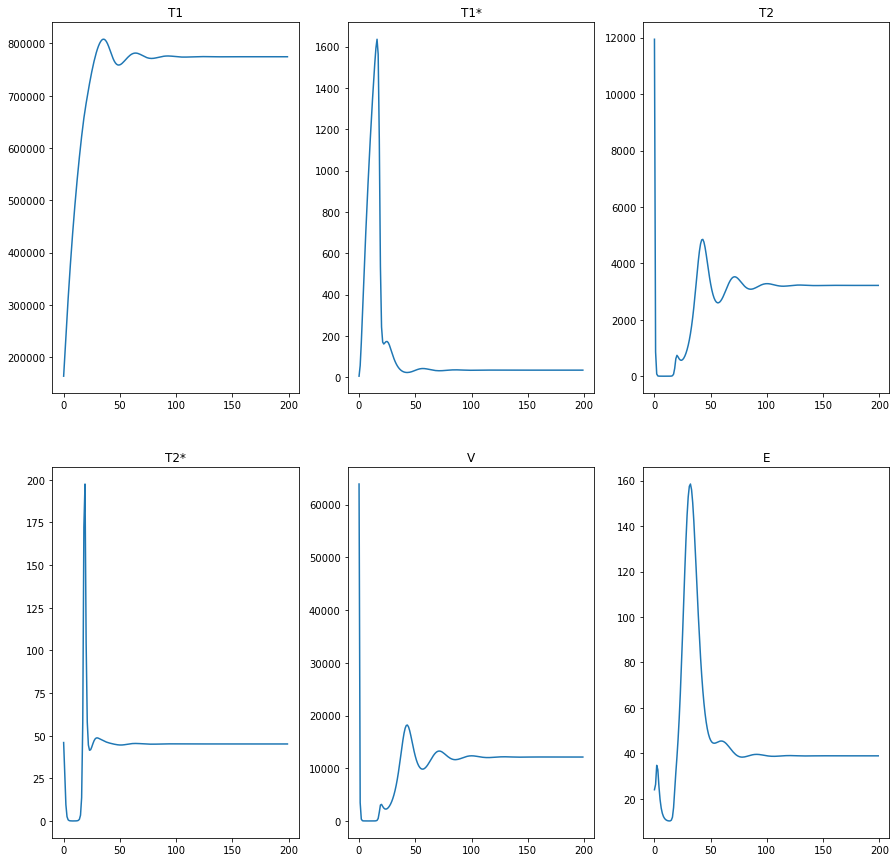

In [151]:
fig, axs = plt.subplots(2, 3, figsize=(15, 15))
axs[0,0].plot(T1)
axs[0,0].set_title("T1")
axs[0,1].plot(T1_)
axs[0,1].set_title("T1*")
axs[0,2].plot(T2)
axs[0,2].set_title("T2")
axs[1,0].plot(T2_)
axs[1,0].set_title("T2*")
axs[1,1].plot(V)
axs[1,1].set_title("V")
axs[1,2].plot(E)
axs[1,2].set_title("E")